In [1]:
import os
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from src.utils.data_utils import get_related_videos_with_keywords, keyword_searcher
from src.utils.general_utils import plot_wordcloud
from src.utils.evaluation_utils import diff_in_diff
from sklearn.linear_model import LinearRegression



In [67]:
def get_all_tags(df: pd.DataFrame) -> list[str]:
    df['tags'] = df['tags'].str.lower()
    df['tags'] = df['tags'].str.replace("world cup", "world_cup")
    df['tags'] = df['tags'].str.replace("table tennis", "table_tennis")
    df['tags'] = df['tags'].str.replace("ping pong", "table_tennis")
    
    all_tags = []
    for tags in df['tags']:
        tag_list = tags.split(",") # "a, b c, d" -> ["a", "b c", "d"]
        for sentence in tag_list:
            all_tags.extend(sentence.split()) # "b c" -> ["b", "c"]
    
    return all_tags

In [2]:
DATA_PATH = "../data"
df_vd_sports = pd.read_parquet(DATA_PATH+"/filtered_sport_category_metadata.parquet",engine="fastparquet")
# Change upload_date to datetime
df_vd_sports["upload_date"] = pd.to_datetime(df_vd_sports["upload_date"], format="%Y-%m-%d %H:%M:%S")
df_vd_sports['tags'] = df_vd_sports['tags'].str.lower()
df_vd_sports['upload_year_month'] = df_vd_sports['upload_date'].dt.to_period('M') 
# engagement rate \text{Engagement Rate} = (like_count + dislike_count)\view_count
df_vd_sports['engagement_rate'] = (df_vd_sports['like_count'] + df_vd_sports['dislike_count']) / df_vd_sports['view_count']

Replace tags

In [3]:
df_vd_sports['tags'] = df_vd_sports['tags'].str.replace("world cup", "world_cup")
df_vd_sports['tags'] = df_vd_sports['tags'].str.replace("table tennis", "table_tennis")
df_vd_sports['tags'] = df_vd_sports['tags'].str.replace("ping pong", "table_tennis")

In [23]:
df_vd_sports.head()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,upload_year_month,engagement_rate
0,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:57.427254,Can I catch 100 lbs of catfish LIVE. Me and Ja...,35.0,JOeSxtcNdHQ,8620,1673.0,"catfishing,fishing,fishing challenge,catfish,c...",Catching 100 lbs of Catfish 🔴Live,2019-10-01,48737.0,2019-10,0.035045
1,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:58.108323,,15.0,EPMLTw2zINw,355,1297.0,,big cat,2019-10-01,19999.0,2019-10,0.065603
2,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:58.773085,Are you ready to enter the high fashion world ...,78.0,Y1_pK68iSYQ,603,3305.0,"catfishing,how to catch catfish,fishing,classy...",Classy Catfishing - How to Catch Catfish the P...,2019-09-28,58518.0,2019-09,0.057811
3,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:59.465346,Saltwater fishing out of Newquay Cornwall UK. ...,70.0,jF8TSo3ZfTc,1426,1889.0,"fishing,fishing uk,angling,sea angling,sea ang...",2 Day Saltwater Fishing Catch & Cook - UK Sea ...,2019-09-21,71998.0,2019-09,0.027209
4,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:40:00.188768,My family spent 3 weeks touring England and fi...,73.0,Gp00dNaVouo,990,2699.0,"fishing,catfish,wels catfish,how to catch catf...",How to Catch Wels Catfish - Fishing for Catfis...,2019-09-14,101924.0,2019-09,0.027197


Extract sports 

In [9]:

target_sports = [
    "soccer", "football", "cricket", "hockey", 
    "tennis", "volleyball", "baseball", "rugby", 
    "golf", "basketball", "skating",
    "swimming", "wrestling", "table_tennis", "badminton",
    "cycling", "boxing", "athletics", "judo", "karate"
]
target_sport_data = pd.DataFrame()
for sport in target_sports:
    filtered_sport_data = df_vd_sports[df_vd_sports['tags'].apply(lambda x: sport in x.split(','))]
    target_sport_data = pd.concat([target_sport_data, filtered_sport_data])

In [29]:
target_sport_data=target_sport_data.drop_duplicates(subset=['display_id']).reset_index(drop=True)

In [170]:
def sport_analysis(data_all,data_sport,sport_name=None):
    monthly_count = data_sport.groupby('upload_year_month').size()
    plt.figure(figsize=(12, 8))
    monthly_count.plot(kind='line', figsize=(12, 6), colormap='tab20', linewidth=2)

    plt.title('Monthly Upload Counts for {}'.format(sport_name), fontsize=16)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Number of Uploads', fontsize=14)
    # plt.legend(title='Sports', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    autocorrelation = monthly_count.autocorr(lag=1)
    print("Autocorrelation: ", autocorrelation)


    #------------------------------
    print("periodic analysis")
    # フーリエ変換の計算
    fft_values = np.fft.fft(monthly_count)

    # 振幅スペクトルを取得（絶対値）
    fft_amplitude = np.abs(fft_values)

    # 周波数軸を計算
    frequencies = np.fft.fftfreq(len(fft_values))

    # 正の周波数のみを使用
    positive_frequencies = frequencies[:len(frequencies)//2]
    positive_amplitudes = fft_amplitude[:len(fft_amplitude)//2]

    # 周期（月数）に変換
    periods = 1 / positive_frequencies

    # 周期が無限大になる値（周波数が0の場合）を除去
    periods = periods[1:]  # 周波数0の部分を除く
    positive_amplitudes = positive_amplitudes[1:]  # 同様に振幅も除去
    threshold = 5000
    filtered_periods = periods[positive_amplitudes >= threshold]
    filtered_amplitudes = positive_amplitudes[positive_amplitudes >= threshold]

    # プロット
    plt.figure(figsize=(12, 8))
    plt.bar(filtered_periods, filtered_amplitudes, width=0.5, color='blue')
    plt.title('Filtered Frequency Spectrum (Amplitude >= 5000)', fontsize=16)
    plt.xlabel('Period (Months)', fontsize=14)
    plt.ylabel('Amplitude', fontsize=14)
    plt.grid(True)

    # x軸のラベルを細かく調整
    plt.xticks(np.arange(min(filtered_periods), max(filtered_periods) + 1, step=1), rotation=45)

    plt.tight_layout()
    plt.show()
    #------------------------------

    total_sports_videos = data_all.groupby('upload_year_month').size()

    sport_video_count = data_sport.groupby('upload_year_month').size()

    golf_trend = (sport_video_count / total_sports_videos).fillna(0)  # NaNを0で置き換える
    plt.figure(figsize=(12, 6))
    golf_trend.plot(kind='line', figsize=(12, 6), colormap='tab20', linewidth=2)

    plt.title('{} Video Upload Trends'.format(sport_name))
    plt.xlabel('Month')
    plt.ylabel('Proportion of {} related video'.format(sport_name))
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    #-----------------------------
    # user engagement
    monthly_engagement = data_sport.groupby('upload_year_month')['engagement_rate'].agg(['mean', 'median']).reset_index()

    tick_positions = range(0, len(monthly_engagement), 4)
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_engagement['upload_year_month'].astype(str), monthly_engagement['mean'], marker='o', label='Mean Engagement Rate')
    plt.plot(monthly_engagement['upload_year_month'].astype(str), monthly_engagement['median'], marker='s', label='Median Engagement Rate', linestyle='--')
    plt.title('Monthly Engagement Rate of {}'.format(sport_name))
    plt.xlabel('Month')
    plt.ylabel('Engagement Rate')
    plt.xticks(tick_positions, monthly_engagement['upload_year_month'].astype(str).iloc[tick_positions], rotation=45)  # ラベルを間引く
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # #-----------------------------
    # # q score
    # data_sport['q_score']=(data_sport['like_count'] - data_sport['dislike_count']) / (data_sport['like_count'] + data_sport['dislike_count'])
    # monthly_engagement = data_sport.groupby('upload_year_month')['q_score'].agg(['mean', 'median']).reset_index()

    # tick_positions = range(0, len(monthly_engagement), 4)
    # plt.figure(figsize=(12, 6))
    # plt.plot(monthly_engagement['upload_year_month'].astype(str), monthly_engagement['mean'], marker='o', label='Mean Q score Rate')
    # plt.plot(monthly_engagement['upload_year_month'].astype(str), monthly_engagement['median'], marker='s', label='Median Q score Rate', linestyle='--')
    # plt.title('Monthly Q score of {}'.format(sport_name))
    # plt.xlabel('Month')
    # plt.ylabel('Q score')
    # plt.xticks(tick_positions, monthly_engagement['upload_year_month'].astype(str).iloc[tick_positions], rotation=45)  # ラベルを間引く
    # plt.legend()
    # plt.grid()
    # plt.tight_layout()
    # plt.show()

    #-------------------------------------
    # how many channels are active over time???

    

## 2016 Olympic


From 2016 olympic in Lio, golf and rugby are accepted as olympic sports. This decision was made in 2009. Those sports are good examples to see how a major sport event affect the engagements over years. 

#### golf

In [31]:
df_golf_sport_category_metadata=target_sport_data[target_sport_data['tags'].apply(lambda x: "golf" in x)]

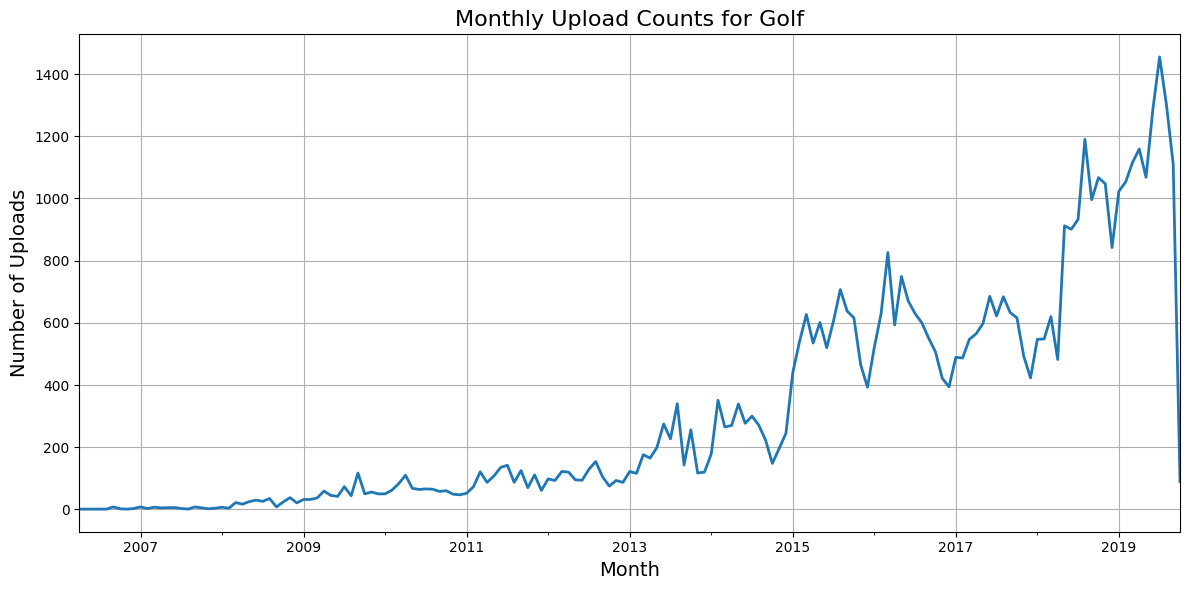

Autocorrelation:  0.9438557400701649
periodic analysis


/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_61089/2580266108.py:33: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


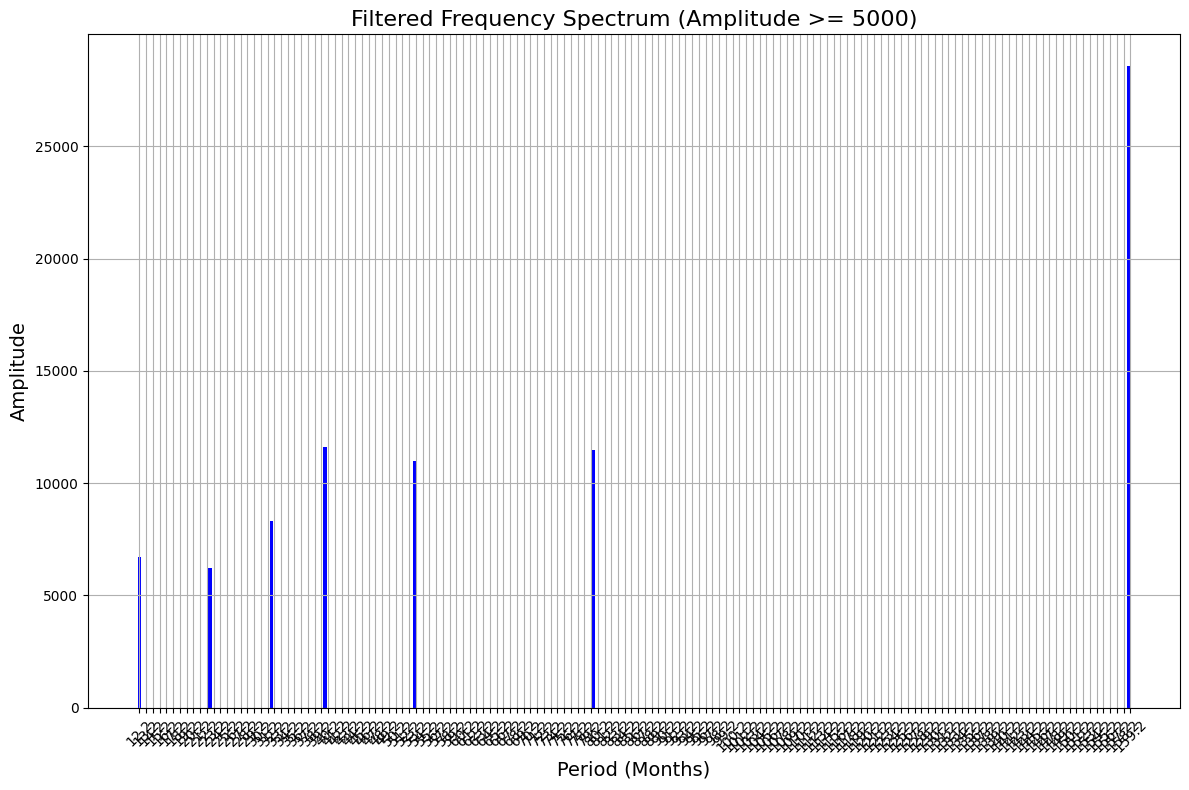

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_61089/2580266108.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


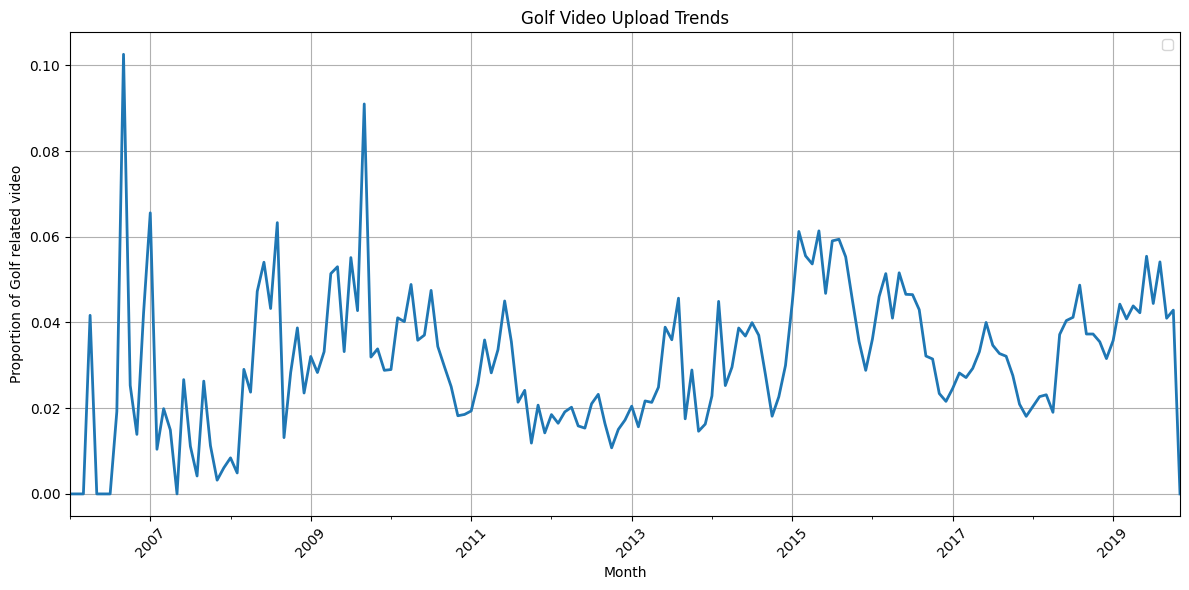

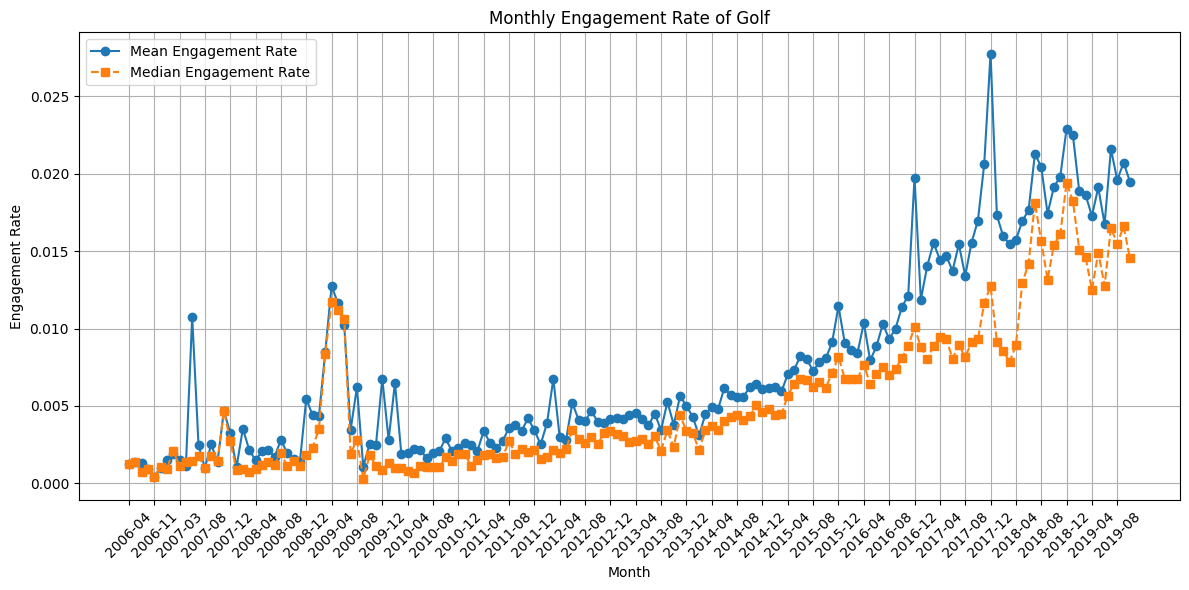

In [171]:
sport_analysis(target_sport_data,df_golf_sport_category_metadata,"Golf")

#### rugby

In [34]:
df_rugby_sport_category_metadata=target_sport_data[target_sport_data['tags'].apply(lambda x: "rugby" in x)]
df_rugby_sport_category_metadata.shape


(33448, 14)

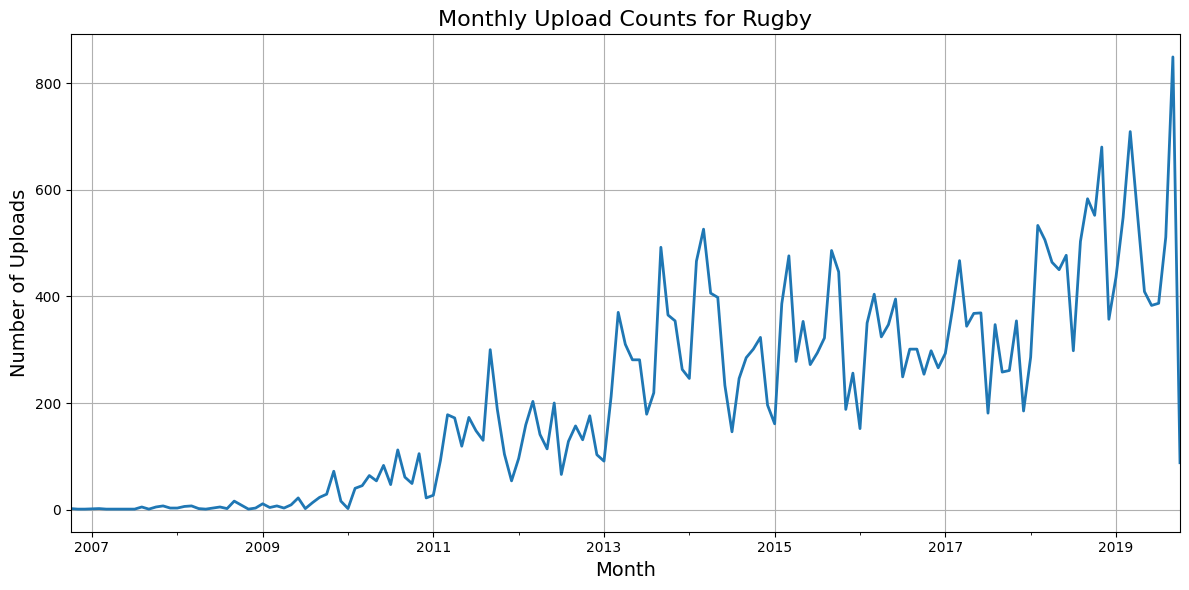

Autocorrelation:  0.8113179850990403
periodic analysis
period [154.          77.          51.33333333  38.5         30.8
  25.66666667  22.          19.25        17.11111111  15.4
  14.          12.83333333  11.84615385  11.          10.26666667
   9.625        9.05882353   8.55555556   8.10526316   7.7
   7.33333333   7.           6.69565217   6.41666667   6.16
   5.92307692   5.7037037    5.5          5.31034483   5.13333333
   4.96774194   4.8125       4.66666667   4.52941176   4.4
   4.27777778   4.16216216   4.05263158   3.94871795   3.85
   3.75609756   3.66666667   3.58139535   3.5          3.42222222
   3.34782609   3.27659574   3.20833333   3.14285714   3.08
   3.01960784   2.96153846   2.90566038   2.85185185   2.8
   2.75         2.70175439   2.65517241   2.61016949   2.56666667
   2.52459016   2.48387097   2.44444444   2.40625      2.36923077
   2.33333333   2.29850746   2.26470588   2.23188406   2.2
   2.16901408   2.13888889   2.10958904   2.08108108   2.05333333
   2.026

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_61089/1600196432.py:33: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


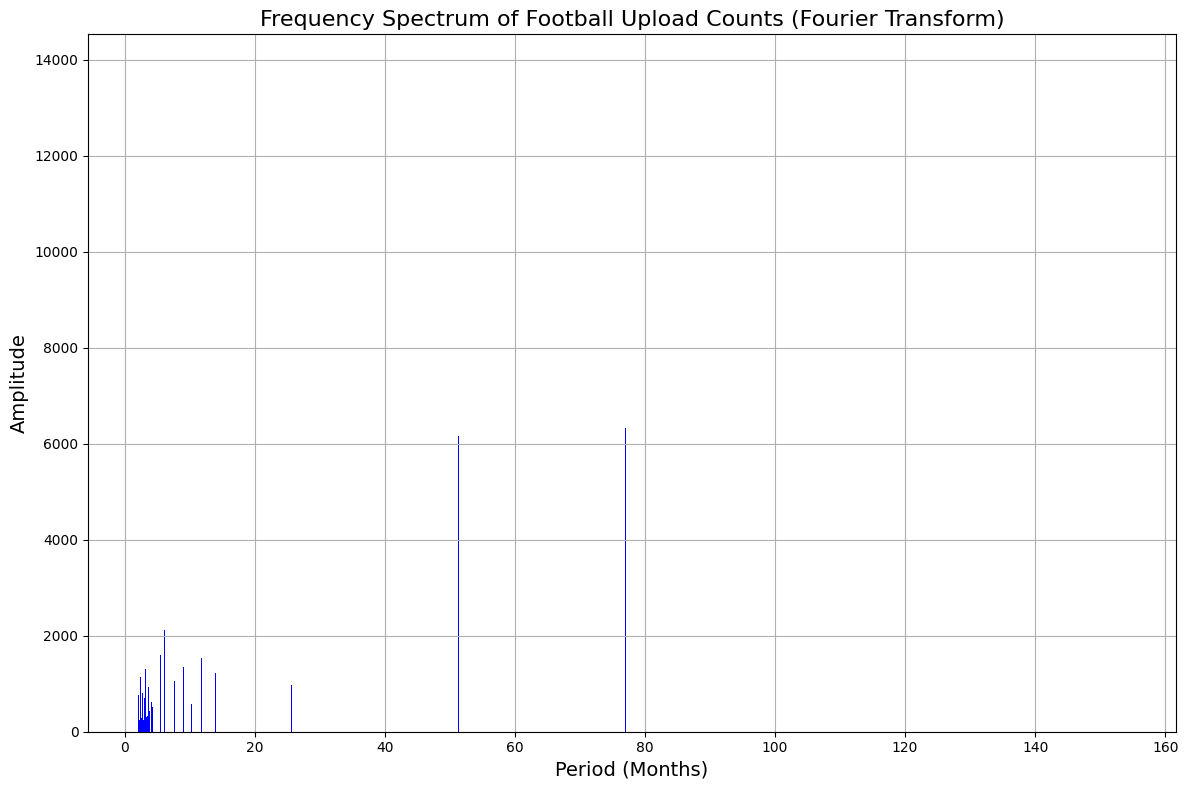

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_61089/1600196432.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


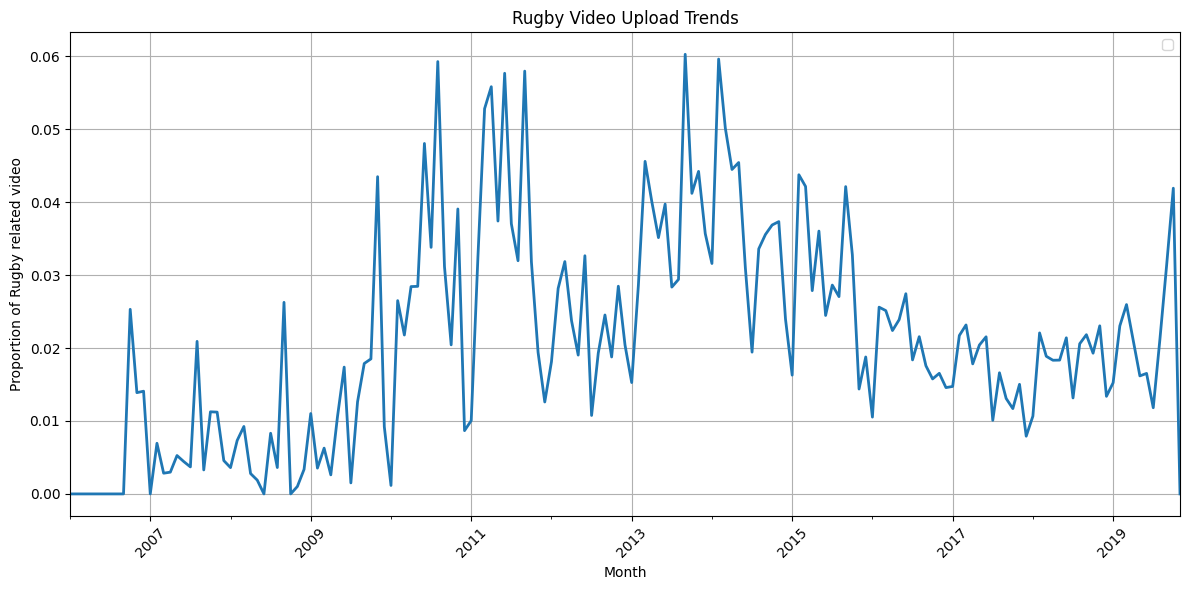

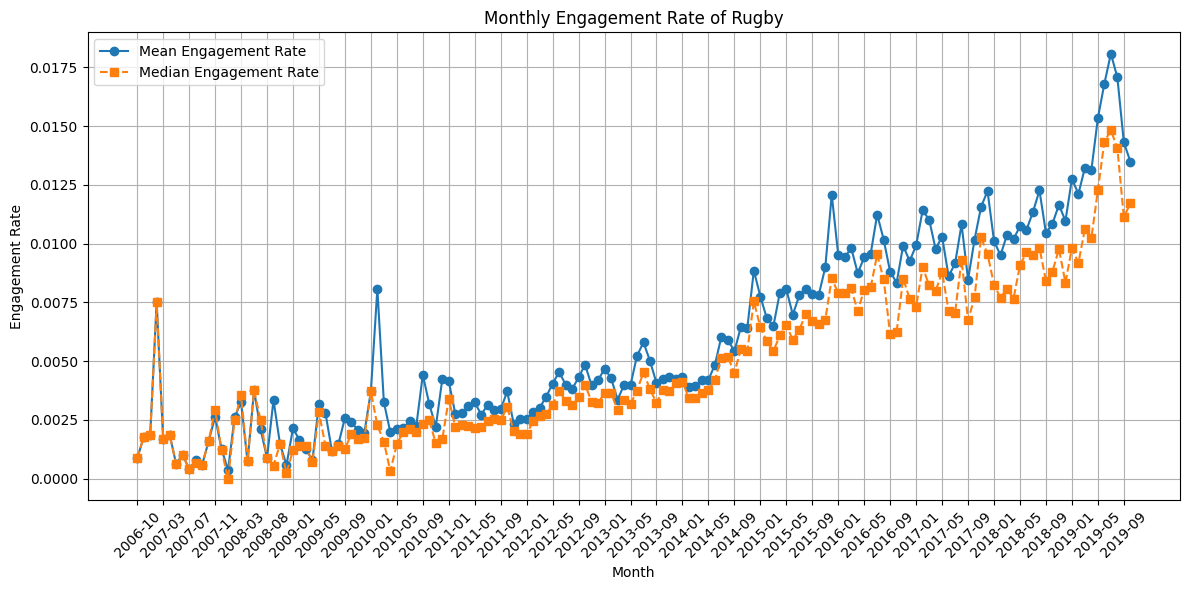

In [167]:
sport_analysis(target_sport_data,df_rugby_sport_category_metadata,"Rugby")

#### Karate

In [46]:
df_karate_sport_category_metadata=target_sport_data[target_sport_data['tags'].apply(lambda x: "karate" in x)]
df_karate_sport_category_metadata.shape

(34367, 14)

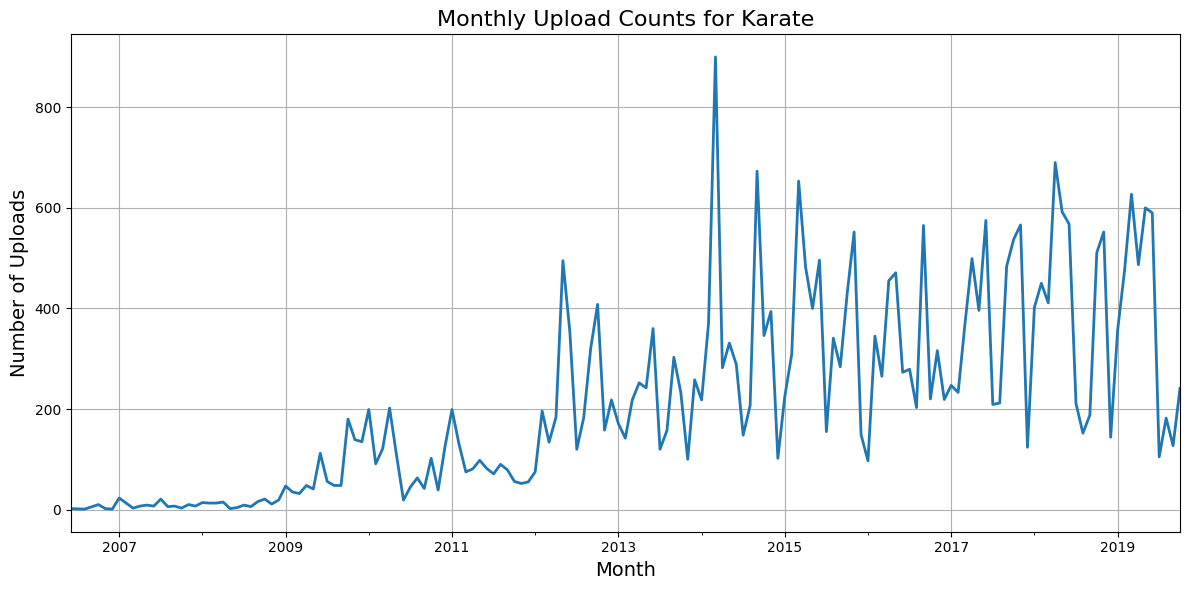

Autocorrelation:  0.6500023771301623
periodic analysis
period [158.          79.          52.66666667  39.5         31.6
  26.33333333  22.57142857  19.75        17.55555556  15.8
  14.36363636  13.16666667  12.15384615  11.28571429  10.53333333
   9.875        9.29411765   8.77777778   8.31578947   7.9
   7.52380952   7.18181818   6.86956522   6.58333333   6.32
   6.07692308   5.85185185   5.64285714   5.44827586   5.26666667
   5.09677419   4.9375       4.78787879   4.64705882   4.51428571
   4.38888889   4.27027027   4.15789474   4.05128205   3.95
   3.85365854   3.76190476   3.6744186    3.59090909   3.51111111
   3.43478261   3.36170213   3.29166667   3.2244898    3.16
   3.09803922   3.03846154   2.98113208   2.92592593   2.87272727
   2.82142857   2.77192982   2.72413793   2.6779661    2.63333333
   2.59016393   2.5483871    2.50793651   2.46875      2.43076923
   2.39393939   2.35820896   2.32352941   2.28985507   2.25714286
   2.22535211   2.19444444   2.16438356   2.13513514 

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_61089/1600196432.py:33: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


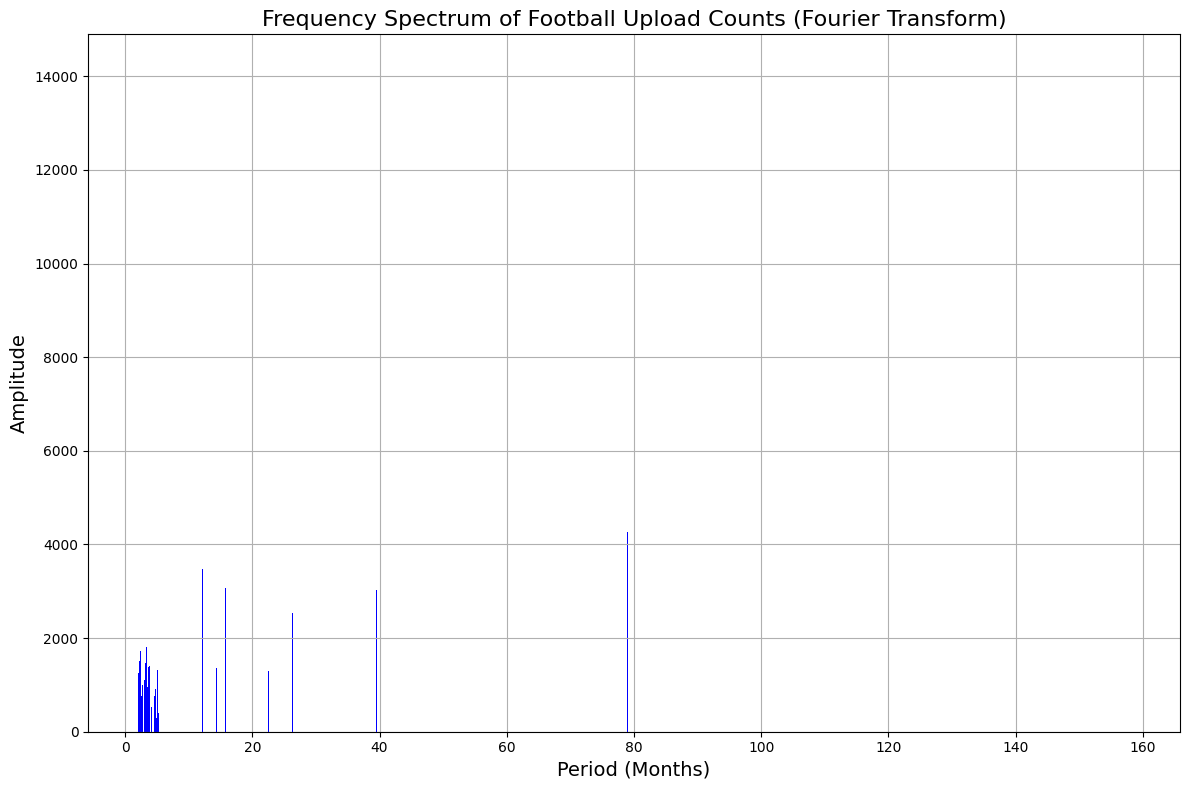

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_61089/1600196432.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


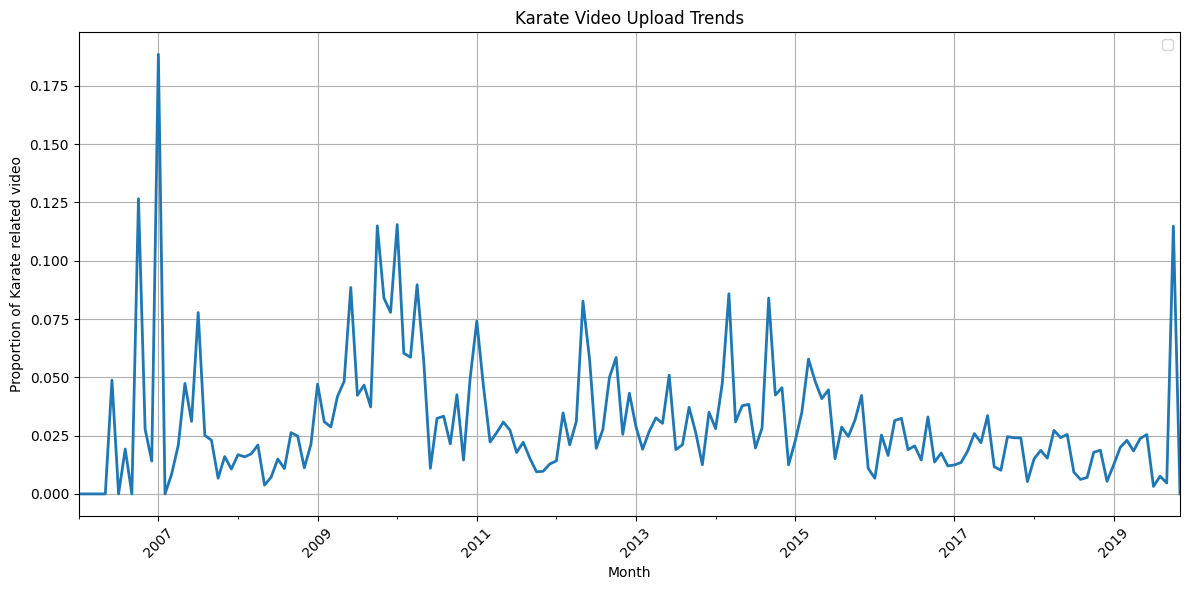

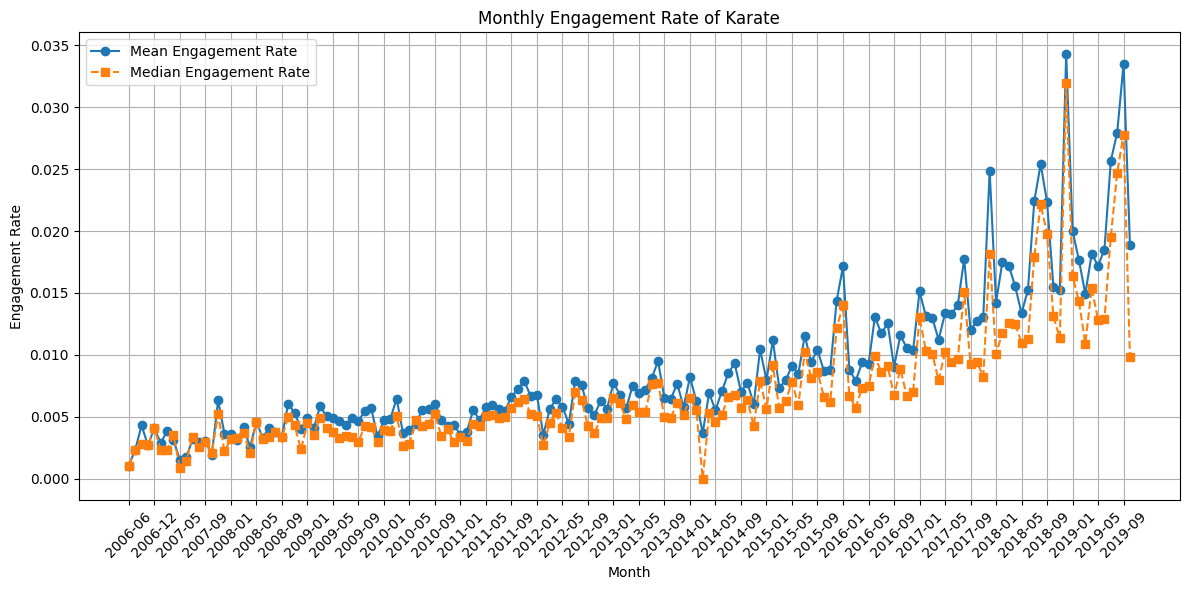

In [168]:
sport_analysis(target_sport_data,df_karate_sport_category_metadata,"Karate")

### football

In [48]:
df_football_sport_category_metadata=target_sport_data[target_sport_data['tags'].apply(lambda x: "football" in x)]
df_football_sport_category_metadata.shape

(457639, 14)

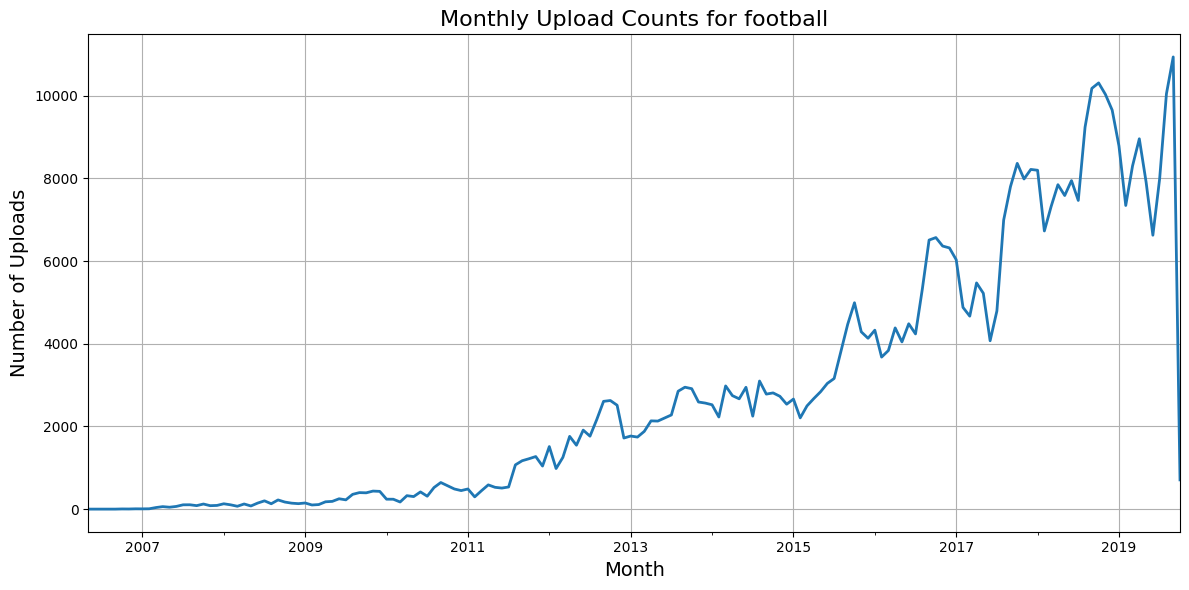

Autocorrelation:  0.9485157683112073
periodic analysis
period [162.          81.          54.          40.5         32.4
  27.          23.14285714  20.25        18.          16.2
  14.72727273  13.5         12.46153846  11.57142857  10.8
  10.125        9.52941176   9.           8.52631579   8.1
   7.71428571   7.36363636   7.04347826   6.75         6.48
   6.23076923   6.           5.78571429   5.5862069    5.4
   5.22580645   5.0625       4.90909091   4.76470588   4.62857143
   4.5          4.37837838   4.26315789   4.15384615   4.05
   3.95121951   3.85714286   3.76744186   3.68181818   3.6
   3.52173913   3.44680851   3.375        3.30612245   3.24
   3.17647059   3.11538462   3.05660377   3.           2.94545455
   2.89285714   2.84210526   2.79310345   2.74576271   2.7
   2.6557377    2.61290323   2.57142857   2.53125      2.49230769
   2.45454545   2.41791045   2.38235294   2.34782609   2.31428571
   2.28169014   2.25         2.21917808   2.18918919   2.16
   2.13157895   2.103

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_61089/1600196432.py:33: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


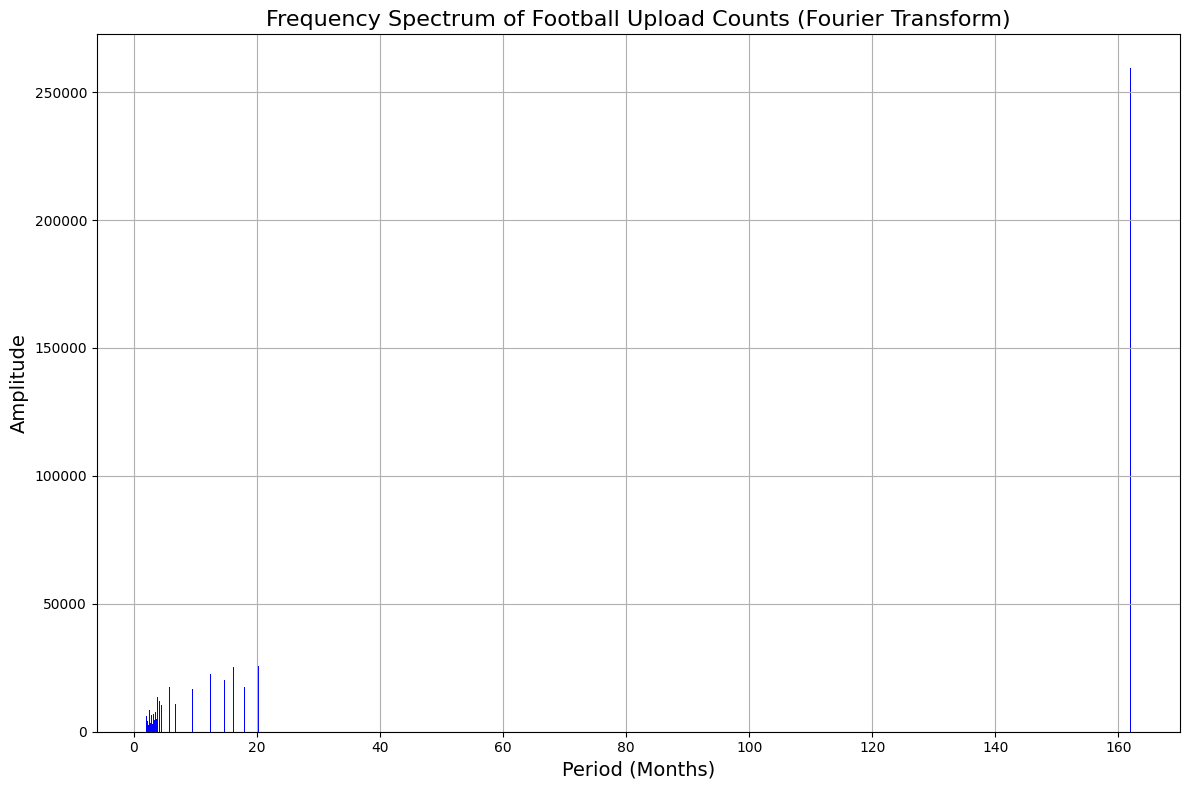

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_61089/1600196432.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


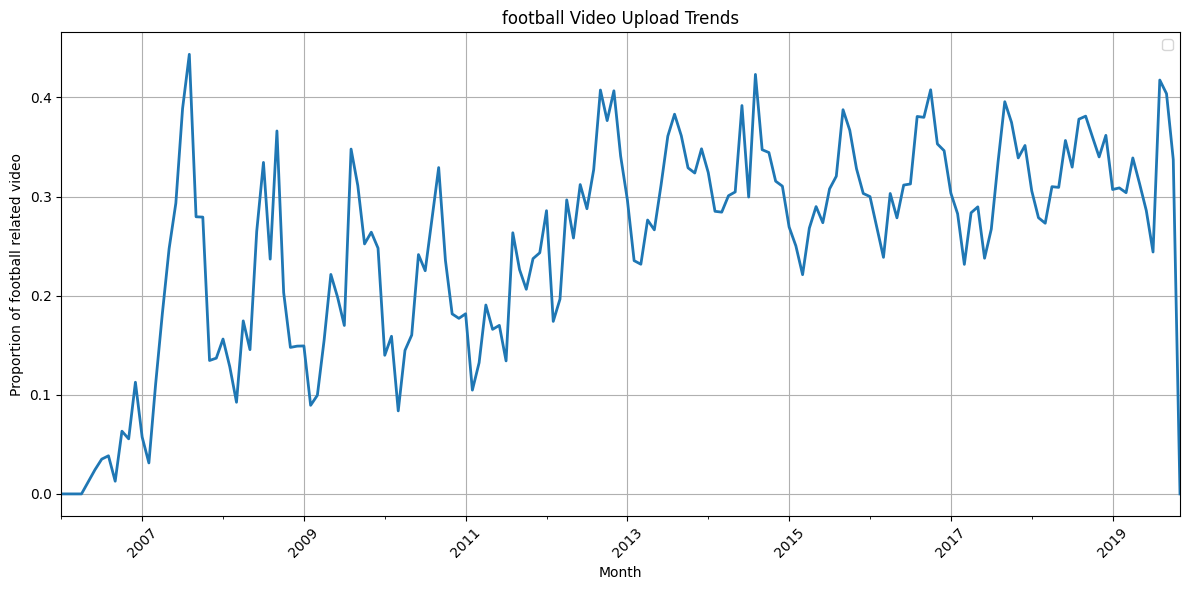

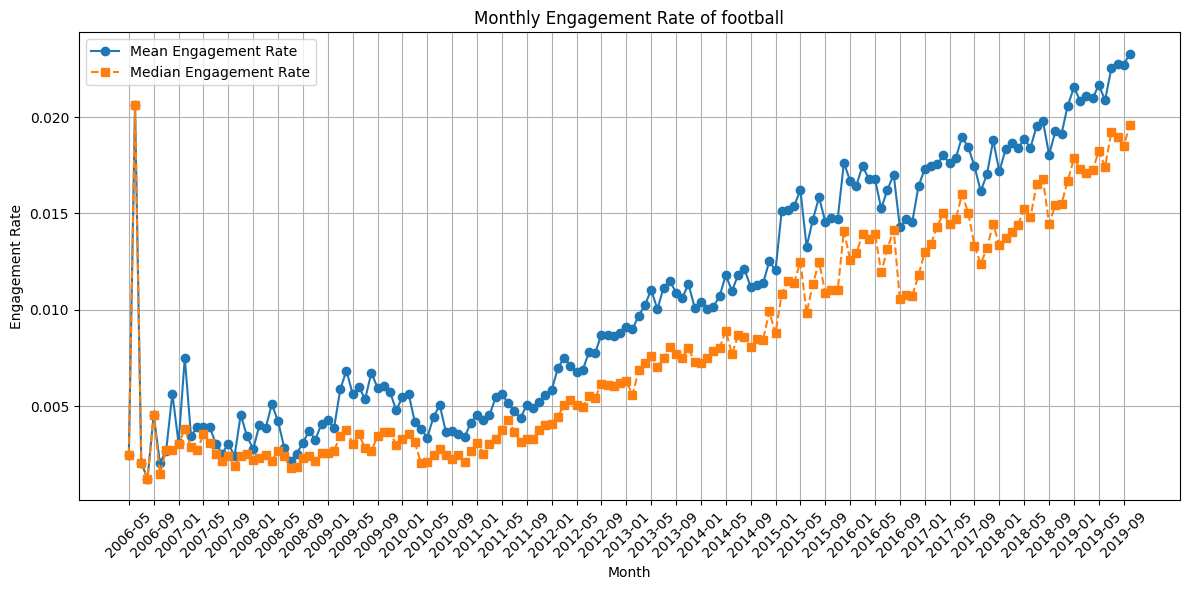

In [169]:
sport_analysis(target_sport_data,df_football_sport_category_metadata,"football")

#### table tennis

In [50]:
df_tabletennis_sport_category_metadata=target_sport_data[target_sport_data['tags'].apply(lambda x: "table_tennis" in x)]
df_tabletennis_sport_category_metadata.shape

(15388, 14)

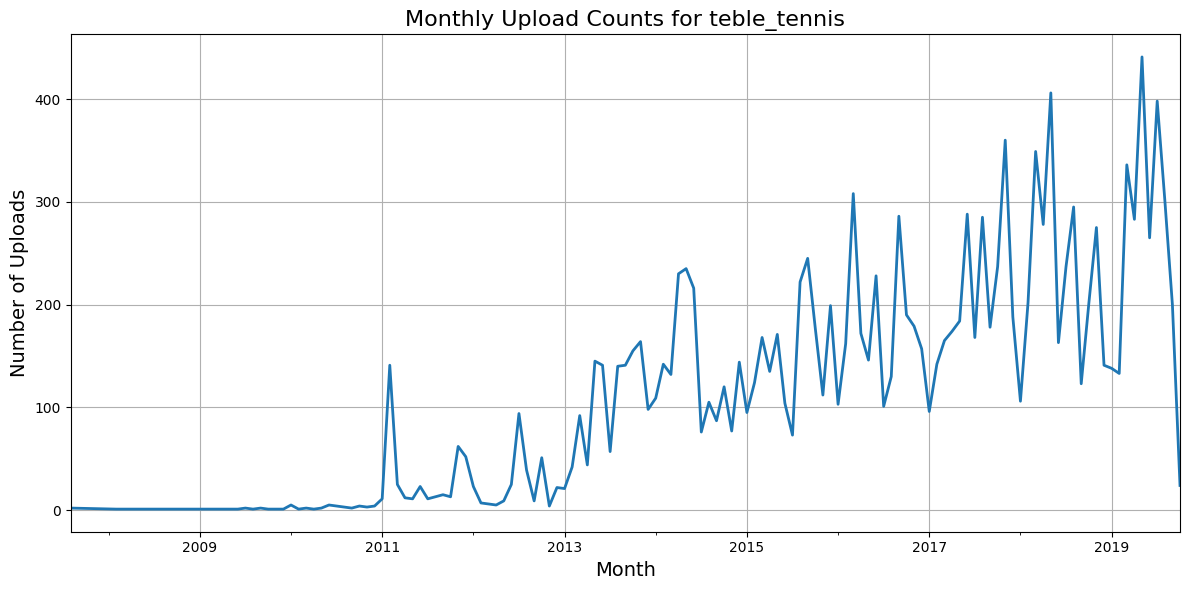

periodic analysis
[np.float64(2.5317460317460316), np.float64(3.5317460317460316), np.float64(4.531746031746032), np.float64(5.531746031746032), np.float64(6.531746031746032), np.float64(7.531746031746032), np.float64(8.531746031746032), np.float64(9.531746031746032), np.float64(10.531746031746032), np.float64(11.531746031746032), np.float64(12.531746031746032), np.float64(14.531746031746032), np.float64(15.531746031746032), np.float64(18.53174603174603), np.float64(21.53174603174603), np.float64(25.53174603174603), np.float64(31.53174603174603), np.float64(42.53174603174603), np.float64(63.531746031746025), np.float64(127.53174603174602)]


/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_61089/2657679314.py:33: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


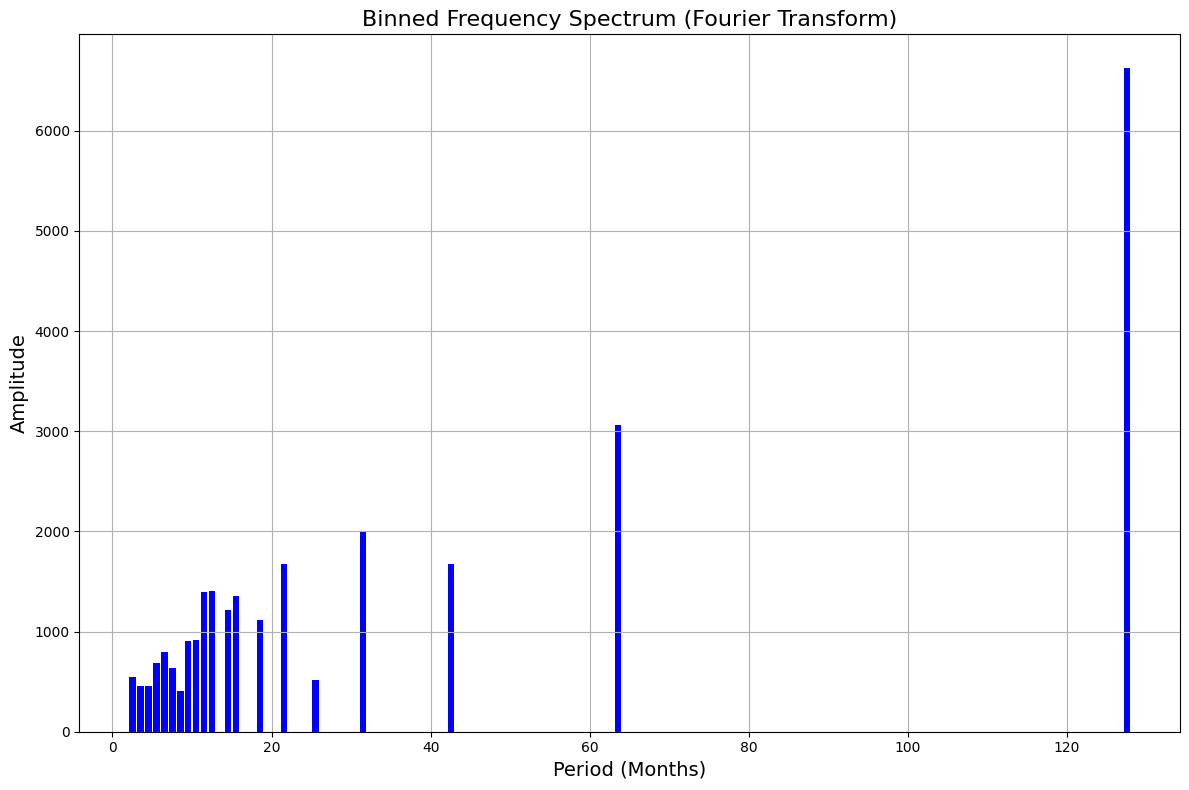

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_61089/2657679314.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


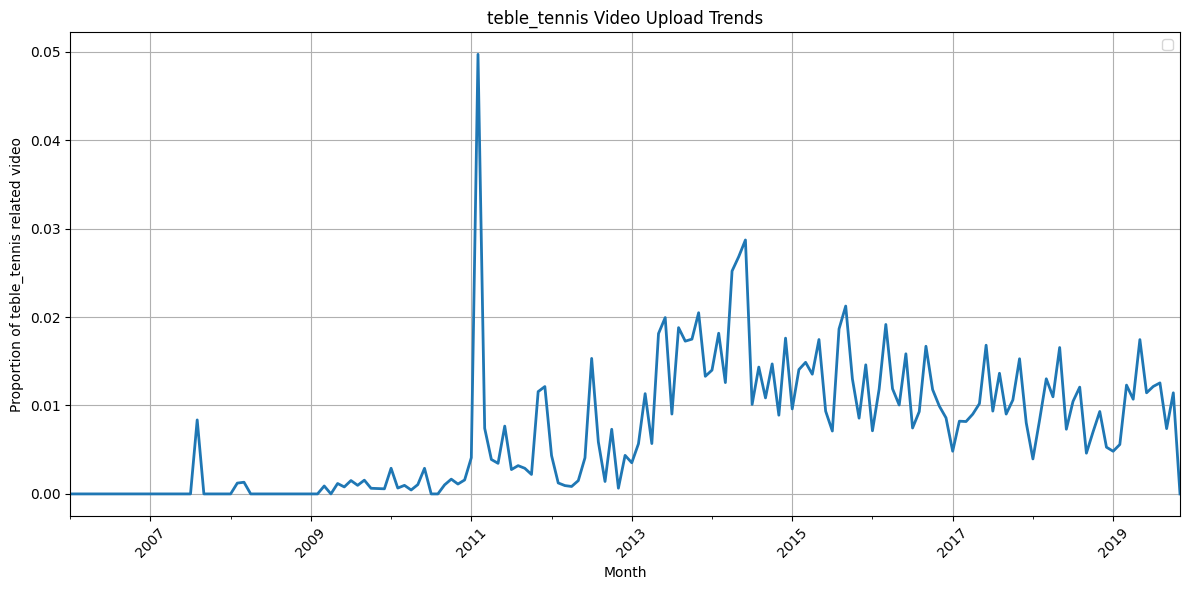

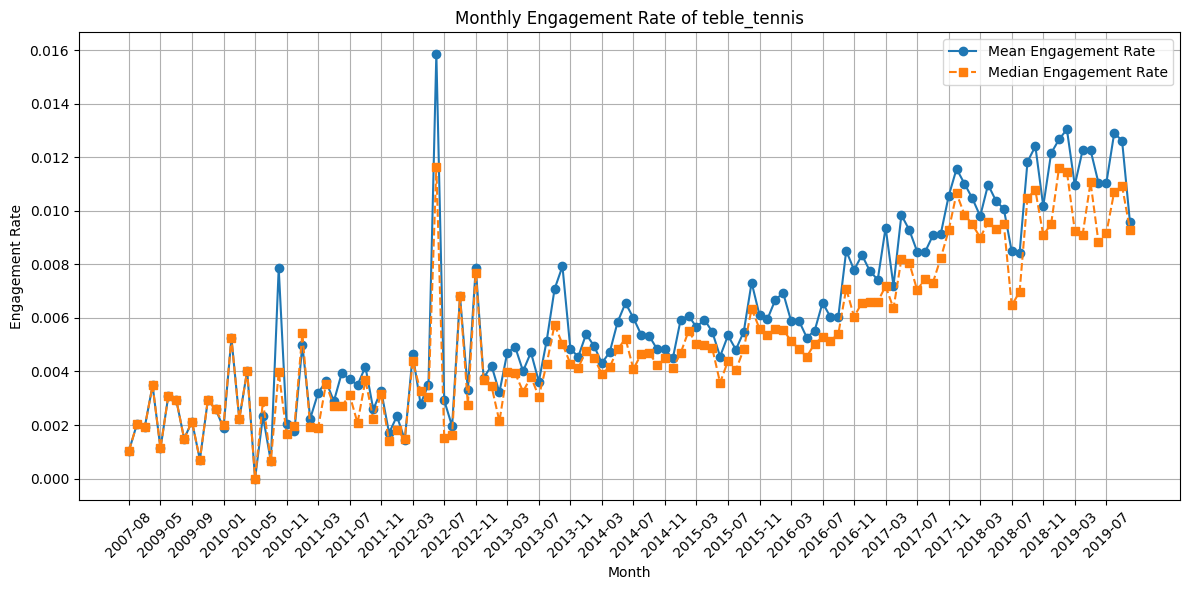

In [128]:
sport_analysis(target_sport_data,df_tabletennis_sport_category_metadata,"teble_tennis")

What happened in early 2011????

In [66]:
df_tabletennis_sport_category_metadata_2011=df_tabletennis_sport_category_metadata[(df_tabletennis_sport_category_metadata['upload_date'].dt.year == 2011)]

In [73]:
df_tabletennis_sport_category_metadata_2011.value_counts('channel_id')

channel_id
UCnpt_griacMF15CpK0rFEAA    245
UC3xMsYwFTMofLgrxIf6CwQw     57
UCmjTfPl_URvszq3_WYM5bnA     46
UCbjBQpnbumVcxZN6MPhsZQA     15
UC9ckyA_A3MfXUa0ttxMoIZw      8
UCqA1KASrQLjLVNK9KnFKxFQ      7
UCWw6scNyopJ0yjMu1SyOEyw      2
UCko0aUhfXFY4FaXuGoB0tsA      2
UC7JKiKZ5xphFgqrZAtsYlTQ      1
UCFAq4psKb4b3bYS6VaNbtoQ      1
UCWJ2lWNubArHWmf3FIHbfcQ      1
UCblfuW_4rakIf2h6aqANefA      1
UCd2KNtfphz8HvYzM4pwtHmg      1
UCflcTDN0OO8EktqDKysjSHw      1
UCjDhDUy4rFXE9cPYq9jLlyw      1
Name: count, dtype: int64

In [78]:
df_tabletennis_sport_category_metadata_2011['channel_id'].nunique()

15

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_61089/3832968893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tags'] = df['tags'].str.lower()
/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_61089/3832968893.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tags'] = df['tags'].str.replace("world cup", "world_cup")
/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_61089/3832968893.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

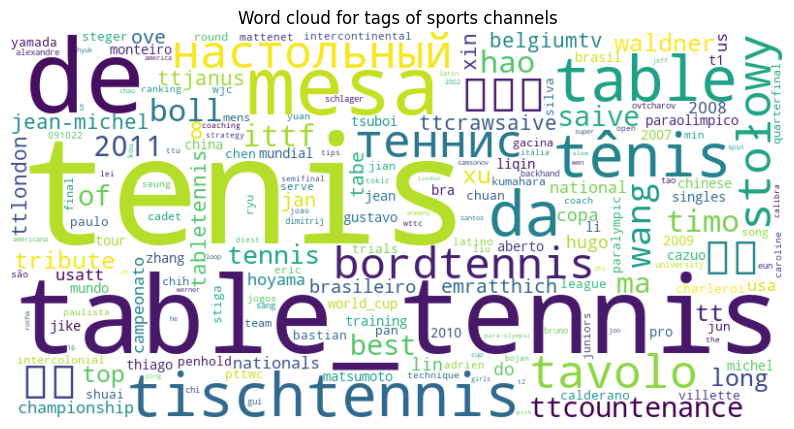

In [68]:
all_tags_sport = get_all_tags(df_tabletennis_sport_category_metadata_2011)
plot_wordcloud(all_tags_sport, "Word cloud for tags of sports channels")
del all_tags_sport

#### TOP 5 popular sport
football, basketball, wrestling, soccer, boxing